In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from SQLTools import *

In [2]:
# check for gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

# list all gpus
print('Found GPUs:')
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print('  ', gpu)


Found GPUs:
   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
def label_to_one_hot(label):
    one_hot = np.zeros(3)
    if label == "rock":
        one_hot[0] = 1
    elif label == "paper":
        one_hot[1] = 1
    elif label == "scissors":
        one_hot[2] = 1
    else:
        raise ValueError(f"Invalid label: {label}")
    return one_hot

def one_hot_to_label(one_hot):
    if one_hot[0] == 1:
        return "rock"
    elif one_hot[1] == 1:
        return "paper"
    elif one_hot[2] == 1:
        return "scissors"
    else:
        raise ValueError(f"Invalid one_hot: {one_hot}")

In [4]:
dataset = Extract_TF_Dataset("./Database/kaggle_data.db", label_to_one_hot)

(128, 128, 3)
tf.Tensor(0.14525889, shape=(), dtype=float32)


Text(0.5, 1.0, 'paper')

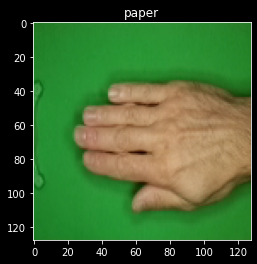

In [5]:
# reduce images to 64x64
# convert images to float32
dataset = dataset.map(lambda img, label: (tf.cast(tf.image.resize(img, (128, 128))/255.0, tf.float32), label))

# shuffle the dataset
dataset = dataset.shuffle(buffer_size=1000)

# take one element from the dataset
sample = next(iter(dataset))
print(sample[0].shape)
print(sample[0][0, 0, 0])
plt.imshow(sample[0])
plt.title(one_hot_to_label(sample[1]))

In [10]:
# clear backend
tf.keras.backend.clear_session()

In [11]:
inputs = layers.Input(shape=(128, 128, 3))
x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [12]:
test_set = dataset.take(100)
train_set = dataset.skip(100).take(1500).repeat(10).batch(32)
val_set = dataset.skip(100).skip(1500).repeat(10).batch(32)

In [13]:
H = model.fit(train_set, epochs=5, validation_data=val_set)

Epoch 1/5
469/469 [==============================] - 45s 79ms/step - loss: 1.4597 - accuracy: 0.3621 - val_loss: 1.1153 - val_accuracy: 0.2498
Epoch 2/5
469/469 [==============================] - 40s 84ms/step - loss: 1.0970 - accuracy: 0.3605 - val_loss: 1.1245 - val_accuracy: 0.2495
Epoch 3/5
469/469 [==============================] - 43s 91ms/step - loss: 1.0958 - accuracy: 0.3631 - val_loss: 1.1320 - val_accuracy: 0.2578
Epoch 4/5
425/469 [==========================>...] - ETA: 2s - loss: 1.0952 - accuracy: 0.3625

KeyboardInterrupt: 

In [ ]:
for i in test_set.take(5):
    print(i[0].shape)
    print(i[1])
    plt.imshow(i[0])

    # predict
    prediction = model.predict(i[0].reshape(1, 128, 128, 3))

    plt.title(one_hot_to_label(i[1]))
    plt.show()